In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-attendance-2.txt")
data["ratio"] = data.Y / data.M
data = data.drop("PersonID", axis=1)

## 問題設定

アルバイトが好きか（A)と学問への興味（Score）を入力に， 3ヶ月の総授業回数(M)を固定した時の出席回数（Y)を予測したい．（つまり出席率＝Y/M)

In [3]:
data

,A,Score,M,Y,ratio
0,0,69,43,38,0.883721
1,1,145,56,40,0.714286
2,0,125,32,24,0.750000
3,1,86,45,33,0.733333
4,1,158,33,23,0.696970
5,0,133,61,60,0.983607
6,0,111,49,35,0.714286
7,1,147,76,47,0.618421
8,0,146,78,63,0.807692
9,0,145,64,57,0.890625


KeyboardInterrupt: 

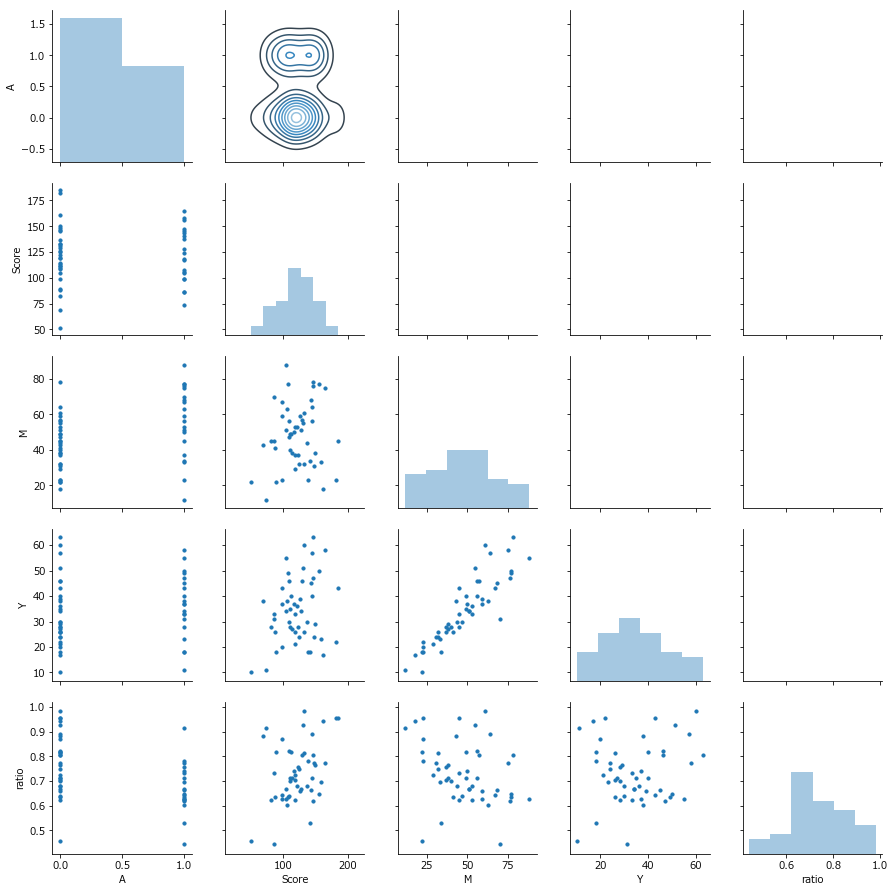

In [4]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r*100),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.PairGrid(data, palette=["red"])
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_upper(corrfunc)

In [ ]:
sns.pairplot(data, hue="A")

### モデル式
$$ logit_i = b_1 + b_2 * A_i + b_3 * Score_i$$
$$Y_i = Binomial(M_i, logit_i)$$

In [ ]:
def model(a, score, m, y):
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    
    logits = b1 + b2 * a + b3 * score
    with pyro.plate("data", len(a)):
        pyro.sample("obs", dist.Binomial(m, logits=logits), obs=y)

In [ ]:
a = torch.tensor(data.A.values).float()
score = torch.tensor(data.Score.values).float() / 200.
m = torch.tensor(data.M.values).float()
y = torch.tensor(data.Y.values).float()

In [ ]:
hmc_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=1000).run(a, score, m, y)

In [ ]:
sites = ["b1", "b2", "b3"]
mcmc_samples = mcmc_posterior.marginal(sites).support(flatten=True)
mcmc_df = pd.DataFrame(EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).cpu().numpy(), columns=sites)

In [ ]:
df_stats = mcmc_df.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
df_stats["mean"] = mcmc_df.mean(0)
df_stats

In [ ]:
mcmc_df.b3.plot()

In [ ]:
def predict_model(a, score, m):
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    
    logits = b1 + b2 * a + b3 * score
    pyro.sample("y", dist.Binomial(m, logits=logits))

In [ ]:
predictive_distribution = TracePredictive(predict_model, mcmc_posterior, num_samples=1000).run(a, score, m)

In [ ]:
y_samples = EmpiricalMarginal(predictive_distribution, "y")._get_samples_and_weights()[0].numpy().mean(0)

plt.plot(torch.arange(0,80).numpy(), torch.arange(0, 80).numpy(), '--')
plt.scatter(data.Y, y_samples)